## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

mirna_tumor.dropna(inplace=True)
mirna_normal.dropna(inplace=True)

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
merged_mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
merged_gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([merged_mirna_tumor, merged_mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = merged_mirna_tumor.shape[0]
n_normal = merged_mirna_normal.shape[0]

# Drop categorical columns
merged_mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
merged_gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(merged_gene_exp_tumor.columns, return_index=True)
merged_gene_exp_tumor = merged_gene_exp_tumor.iloc[:, i]
merged_gene_exp_normal = merged_gene_exp_normal.iloc[:, i]

print "merged_mirna_tumor", merged_mirna_tumor.shape, 'nulls:', merged_mirna_tumor.isnull().sum().sum()
print "merged_mirna_normal", merged_mirna_normal.shape, 'nulls:', merged_mirna_normal.isnull().sum().sum()
print "merged_gene_exp_tumor", merged_gene_exp_tumor.shape, 'nulls:', merged_gene_exp_tumor.isnull().sum().sum()
print "merged_gene_exp_normal", merged_gene_exp_normal.shape, 'nulls:', merged_gene_exp_normal.isnull().sum().sum()

Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

merged_mirna_tumor (503, 1881) nulls: 0
merged_mirna_normal (20, 1881) nulls: 0
merged_gene_exp_tumor (503, 20484) nulls: 0
merged_gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [7]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

NameError: name 'mirna_new' is not defined

## Loading TargetScan database for predicted miRNA-targets interactions

In [6]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs

In [25]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(dys_threshold=0.6)
network.train(miRNAs_tumor=merged_mirna_tumor, targets_tumor=merged_gene_exp_tumor,
              miRNAs_normal=merged_mirna_normal, targets_normal=merged_gene_exp_normal,
              putative_assocs=targetScan_df)
# print nx.bipartite.sets(network.B)

n_A 503
n_B 20


src/models/miRNA_target_network.py:49: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNAs_normal[m]) * np.std(targets_normal[t]))


src/models/miRNA_target_network.py:45: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNAs_tumor[m]) * np.std(targets_tumor[t]))


In [26]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

1881
20484
edges 2301


## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [37]:
network.get_miRNA_groups(mirna_list, smaller_groups=False)

[1,
 2,
 3,
 426,
 426,
 426,
 237,
 4,
 5,
 412,
 6,
 7,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 422,
 385,
 428,
 406,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 420,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 42,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 409,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 407,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 165,
 430,
 355,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 394,
 173,
 174,
 175,
 176,
 405,
 18,
 380,
 178

### Prepare samples for Classification task

In [60]:
X = pandas.concat([mirna_tumor, mirna_normal])
y = X['pathologic_stage']

X.drop(['patient_barcode'], 1, inplace=True)
X.drop(['pathologic_stage'], 1, inplace=True)

pathologic_stage_map = {'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4}
y = y.replace(pathologic_stage_map)
print "mirna_tumor + mirna_normal", X.shape
print "y", y.shape

y.value_counts()

mirna_tumor + mirna_normal (552, 1881)
y (552,)


1    277
2    121
3     84
0     46
4     24
Name: pathologic_stage, dtype: int64

## Create Classifiers

In [63]:
from sklearn.model_selection import train_test_split
from src.models.group_lasso_spams import SPAMSClassifier

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 300,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['loss'] = 'multi-logistic'
param['regul'] = 'group-lasso-l2'
param['lambda1'] = 0.5
# param['lambda2'] = 0.5

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.05, random_state=np.random.randint(0, 10000), stratify=y)

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])

print "X_train", X_train.shape
print "Y_train", Y_train.shape, np.unique(Y_train)

group_l2 = SPAMSClassifier()
group_l2.fit(X_train, Y_train, groups=network.get_miRNA_groups(mirna_list, smaller_groups=True), params=param)

group_l2_large_groups = SPAMSClassifier()
group_l2_large_groups.fit(X_train, Y_train, 
                          groups=network.get_miRNA_groups(mirna_list, smaller_groups=False),
                          params=param)

param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_groups(mirna_list), params=param)

sparse_group_l2_large_groups = SPAMSClassifier()
sparse_group_l2_large_groups.fit(X_train, Y_train, groups=network.get_miRNA_groups(mirna_list, smaller_groups=False), params=param)

X_train (524, 1881)
Y_train (524, 1) [ 0.  1.  2.  3.  4.]


RuntimeError: fistaFlat : Argument sizes are not consistent

## Classification Report

In [54]:
from sklearn import metrics

for model, name in [(group_l2, 'group-lasso-l2'),
                    (group_l2_large_groups, 'group_l2_large_groups'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group-lasso-l2'),
                    (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')]:
    print '\n', name
    print 'non-zero', model.get_selected_miRNAs(mirna_list).shape[0]

    # print metrics.classification_report(Y_train, model.predict(X_train),
    #                                 labels=[-1, 1],
    #                                 target_names=['normal', 'Stages'])

    print metrics.classification_report(Y_test, model.predict(X_test),
                                    labels=[-1, 1],
                                    target_names=['normal', 'Stages'])


group-lasso-l2
non-zero 199
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         2
     Stages       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        28


group_l2_large_groups
non-zero 219
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         2
     Stages       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        28


l1_lasso
non-zero 181
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         2
     Stages       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        28


elastic_net
non-zero 181
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00         2
     Stages       1.00      1.00      1.00        26

avg / total       1.00      1.00      1.00        28


sparse-group-lasso-l2
non

## Loading HMDD database for experimentally validated NSCLC miRNA

In [55]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape, mir2disease_nsclc_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,) ['hsa-let-7g' 'hsa-mir-372' 'hsa-mir-107' 'hsa-mir-21' 'hsa-mir-15a'
 'hsa-mir-16' 'hsa-mir-185' 'hsa-mir-125b' 'hsa-mir-126' 'hsa-mir-100'
 'hsa-mir-9' 'hsa-let-7a' 'hsa-let-7b' 'hsa-let-7d' 'hsa-mir-221'
 'hsa-mir-137' 'hsa-mir-205' 'hsa-mir-96' 'hsa-mir-34a' 'hsa-mir-34b'
 'hsa-mir-34c' 'hsa-mir-222' 'hsa-mir-182' 'hsa-mir-15b']


## Compare models by recall rate

In [56]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate
    
pandas.DataFrame([[name,
                   model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0], 
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
                               validated_miRNAs=HMDD_lung_neoplasm_miRNAs), 
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(), 
                                  validated_miRNAs=HMDD_lung_neoplasm_miRNAs) ] \
                  for model, name in [(group_l2, 'group-lasso-l2'),
                                      (group_l2_large_groups, 'group_l2_large_groups'),
                                      (l1_lasso, 'l1_lasso'),
                                      (elastic_net, 'elastic_net'),
                                      (sparse_group_l2, 'sparse-group-lasso-l2'),
                                      (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')]
                  ], columns=['method', 'no_selected', 'recall_rate', 'precision_rate'])\
    .sort('recall_rate', ascending=False)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,method,no_selected,recall_rate,precision_rate
1,group_l2_large_groups,219,0.707006,0.506849
5,sparse_group_l2_large_groups,219,0.707006,0.506849
0,group-lasso-l2,199,0.675159,0.532663
4,sparse-group-lasso-l2,199,0.675159,0.532663
2,l1_lasso,181,0.636943,0.552486
3,elastic_net,181,0.636943,0.552486


## Check candidate miRNA's if validated

In [57]:
candidate_miRNAs = group_l2_large_groups.get_selected_miRNAs(mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated,groups
53,hsa-mir-148a,0.000126,True,[]
70,hsa-mir-182,0.000095,True,"[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, ..."
104,hsa-mir-22,0.000081,True,"[4, 4, 4, 6, 9]"
128,hsa-mir-30a,-0.000073,True,"[2, 3, 3, 3, 4, 4, 4, 5, 6, 10, 11]"
21,hsa-mir-10a,0.000041,False,[5]
71,hsa-mir-183,0.000041,True,"[2, 3, 4]"
77,hsa-mir-192,0.000038,True,"[2, 2, 2, 3, 3, 7]"
133,hsa-mir-30e,0.000034,True,"[3, 4, 11]"
0,hsa-let-7a-1,-0.000032,True,[]
95,hsa-mir-203a,0.000032,False,[]


In [58]:
candidate_miRNAs = group_l2.get_selected_miRNAs(mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated,groups
50,hsa-mir-148a,0.000126,True,[]
67,hsa-mir-182,0.000095,True,"[2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, ..."
98,hsa-mir-22,0.000081,True,"[4, 4, 4, 6, 9]"
121,hsa-mir-30a,-0.000073,True,"[2, 3, 3, 3, 4, 4, 4, 5, 6, 10, 11]"
20,hsa-mir-10a,0.000041,False,[5]
68,hsa-mir-183,0.000041,True,"[2, 3, 4]"
72,hsa-mir-192,0.000038,True,"[2, 2, 2, 3, 3, 7]"
126,hsa-mir-30e,0.000033,True,"[3, 4, 11]"
0,hsa-let-7a-1,-0.000032,True,[]
89,hsa-mir-203a,0.000032,False,[]


## Validate miRNA-target edges

In [212]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

SPPL3 hsa-mir-369


[autoreload of _pytest.assertion failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name util
]
[autoreload of py.test.cmdline failed: Traceback (most recent call last):
  File "/opt/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named cmdline
]


NameError: name 'miRecords_df' is not defined

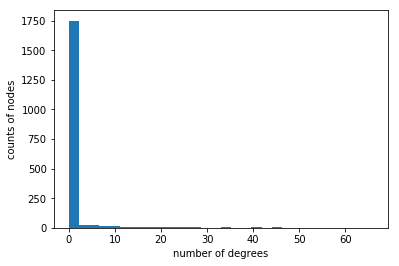

In [114]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()